In [1]:
from autoencoder.unet import UNet
from clickref.model import Click_ref
import torch
from autoencoder.dataloader import * 
import matplotlib.pyplot as plt
from tqdm import tqdm
from create_gt_grids import Gtgrid
from sklearn.metrics import pairwise_distances
from utils import *
from find_same_nucleis import FindSame2
from grids_to_clicks import Grid_to_click
from clickref.metrics import model_predict_with_click

In [2]:
autoencoder = UNet(3, 3).cuda()
autoencoder.load_state_dict(
    torch.load(
        os.path.join(path_pannuke, "weights_autoencoder_CAE_"+str(parameters['n_embedding'])
    )
))
click_ref = Click_ref(7, 3)
click_ref.load_state_dict(
    torch.load(path_weights_click_ref)
)
click_ref.cuda()

Click_ref(
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
  (conv_corr1): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_corr2): Conv2d_new(
    (conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
  )
  (conv_corr3): Conv2d_new(
    (conv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
  )
  (conv_corr4): Conv2d_new(
    (conv): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu): ReLU()
  )
  (conv_corr5): Conv2d_new(
    (conv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
  )
  (conv_corr6): Conv2d_new(
    (conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
  )
  (conv_corr7): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask1): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask2): Conv2d_new(
    (

In [3]:
filename = os.listdir(path_images)[25]
image_input = tifffile.imread(os.path.join(path_images,filename))/255
image = torch.tensor(np.transpose(image_input,(-1,0,1))[None]).cuda().float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


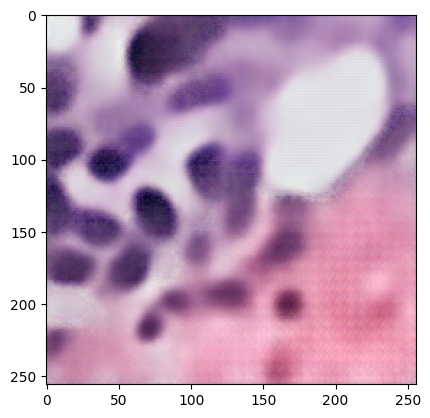

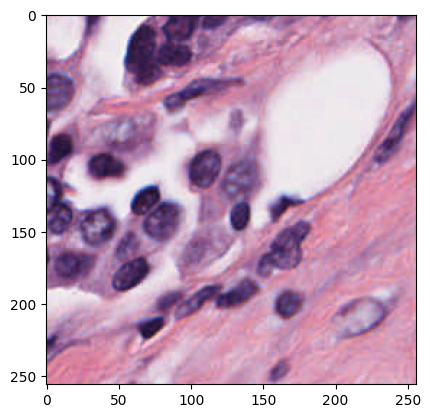

In [4]:
img = np.transpose(autoencoder(image)[0].cpu().detach().numpy()[0],(1,2,0))
plt.imshow(img)
plt.show()
plt.imshow(image_input)
plt.show()

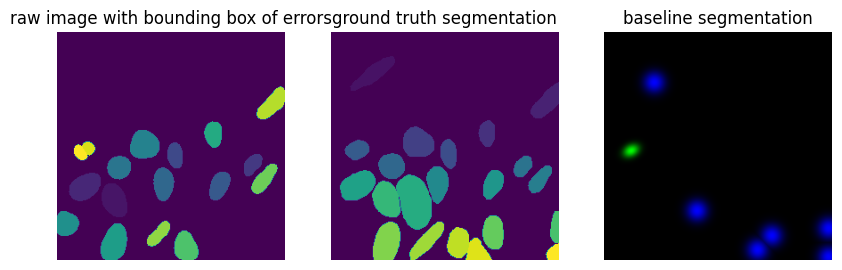

In [5]:
filename = os.listdir(os.path.join(path_stardist_modified,'baseline'))[9]
img_baseline = tifffile.imread(os.path.join(path_stardist_modified,'baseline',filename))
img_gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))
click = tifffile.imread(os.path.join(path_stardist_modified,'click',filename))

fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(img_baseline)
plt.axis("off")
plt.title("raw image with bounding box of errors")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(img_gt)
plt.axis("off")
plt.title("ground truth segmentation")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(click[:,:,:-1])
plt.axis("off")
plt.title("baseline segmentation")
plt.show()

In [6]:
from clickref.metrics import n_channel_to_rgb

### choose image support and error localization

In [7]:
f = FindSame2(df_test,
              autoencoder,
              threshold_images=5,
              threshold_nucleis=0.5,
              baseline = path_stardist_modified)

  0%|                                                    | 0/38 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 38/38 [00:06<00:00,  5.44it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


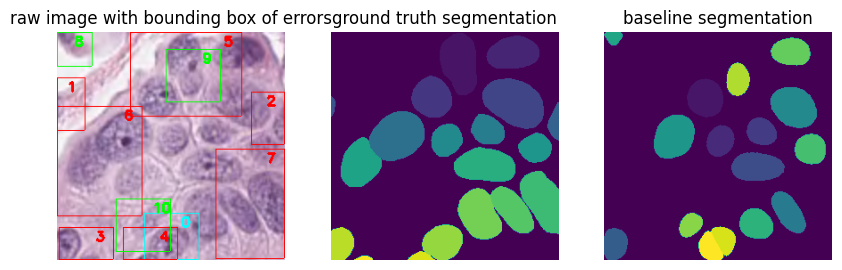

0.00014591217041015625 draw squares
0.00015616416931152344 find_nearest_nuclei
0.0005631446838378906 norm 
0.00010180473327636719 draw squares
0.00010967254638671875 find_nearest_nuclei
0.0002281665802001953 norm 
0.00027298927307128906 draw squares
0.00011181831359863281 find_nearest_nuclei
0.0002162456512451172 norm 
0.00010466575622558594 draw squares
0.0001068115234375 find_nearest_nuclei
0.0002040863037109375 norm 
9.942054748535156e-05 draw squares
0.00010395050048828125 find_nearest_nuclei
0.00020003318786621094 norm 
0.00018215179443359375 draw squares
9.942054748535156e-05 find_nearest_nuclei
0.0002002716064453125 norm 
0.00010180473327636719 draw squares
9.846687316894531e-05 find_nearest_nuclei
0.00020051002502441406 norm 
9.393692016601562e-05 draw squares
9.918212890625e-05 find_nearest_nuclei
0.00019812583923339844 norm 
0.00010275840759277344 draw squares
9.775161743164062e-05 find_nearest_nuclei
0.00019860267639160156 norm 
0.00010251998901367188 draw squares
9.72747802

In [8]:
f.extract_errors(125)

f.show_errors_loc()
f.threshold_images = 1.5
f.select_images_near()
f.threshold_nucleis = 0.035
(
    images_near,
    images_with_same_errors_detected,
    sub_dataset,
    grids,
    filenames_near,
) = f.find_same_nuclei()
print(len(images_with_same_errors_detected))
print(len(filenames_near))

In [11]:
if len(images_with_same_errors_detected)>1:
    for index in images_with_same_errors_detected[1:]:
        filename = filenames_near[index]
        grid = grids[index]
        path_baseline = path_stardist
        g = Grid_to_click(grid, filename, path_baseline)
        click = g.final_click()

        bef, out, baseline = model_predict_with_click(
            filename,
            click_ref,
            path_baseline,
            click,
            count_erase=15,
            radius=3,
        )
        baseline = tifffile.imread(os.path.join(path_baseline,'baseline', filename))
        gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))

        fig = plt.figure(figsize=(10, 7))
        # setting values to rows and column variables
        rows = 1
        columns = 4

        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, 1)

        # showing image
        plt.imshow(bef,cmap='nipy_spectral')
        plt.axis("off")
        plt.title("clickref segmentation")

        # Adds a subplot at the 2nd position
        fig.add_subplot(rows, columns, 2)

        # showing image
        plt.imshow(baseline,cmap='nipy_spectral')
        plt.axis("off")
        plt.title("baseline segmentation")

        # Adds a subplot at thhttp://127.0.0.1:8888/?token=43a6d73987507a6a37f317f6ca6dcc2b0cb958224835ee73e 3rd position
        fig.add_subplot(rows, columns, 3)

        # showing image
        plt.imshow(gt,cmap='nipy_spectral')
        plt.axis("off")
        plt.title("ground truth")

        fig.add_subplot(rows, columns, 4)

        # showing image
        plt.imshow(n_channel_to_rgb(click))
        plt.axis("off")
        plt.title("click generated")
        plt.show()

fp 6
merge 0
split 1
fn 10
[[[9.98954535e-01 4.71498643e-04 5.74035163e-04]
  [9.99996781e-01 2.13664475e-06 1.04287778e-06]
  [9.99999881e-01 8.34816092e-08 3.71646998e-08]
  ...
  [1.00000000e+00 2.47789367e-09 5.74915393e-10]
  [9.99999881e-01 1.70234301e-07 3.67380935e-08]
  [9.99955177e-01 3.75819473e-05 7.21671722e-06]]

 [[9.99999762e-01 2.03924913e-07 3.54937946e-08]
  [1.00000000e+00 3.10170639e-11 4.04467394e-13]
  [1.00000000e+00 7.17666825e-14 3.51045102e-16]
  ...
  [1.00000000e+00 4.60544942e-16 1.03877920e-18]
  [1.00000000e+00 1.04853040e-12 4.82617732e-15]
  [1.00000000e+00 2.71615104e-08 4.45515180e-10]]

 [[1.00000000e+00 3.49352391e-09 3.63725022e-10]
  [1.00000000e+00 4.71082185e-14 1.41084944e-16]
  [1.00000000e+00 1.29112149e-17 1.13834455e-20]
  ...
  [1.00000000e+00 2.04812359e-20 1.63975694e-24]
  [1.00000000e+00 4.71671514e-16 1.30779543e-19]
  [1.00000000e+00 3.04817949e-10 4.73257392e-13]]

 ...

 [[1.00000000e+00 7.49336770e-09 5.79805925e-10]
  [1.0000000

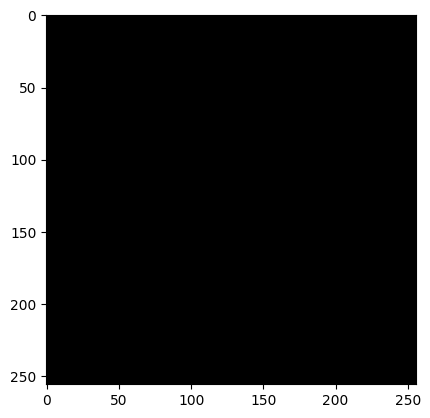

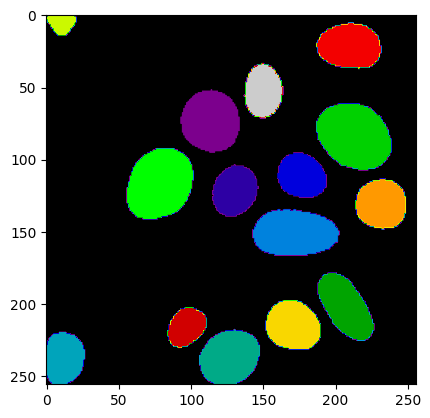

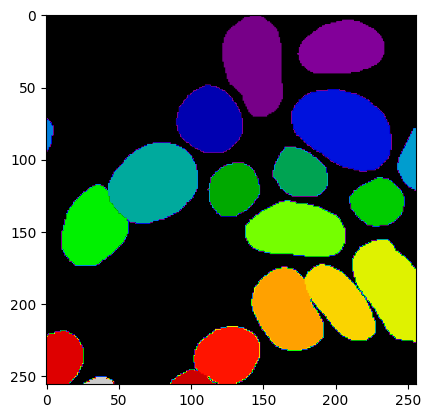

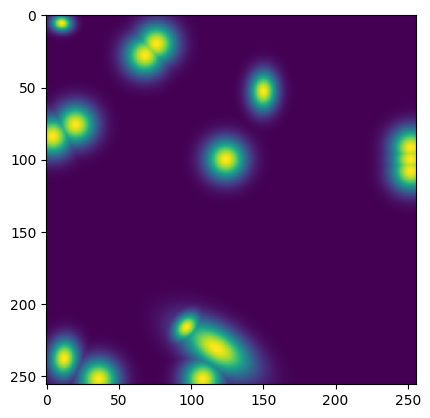

In [9]:
index = 0
filename = filenames_near[index]
grid = grids[index]
path_baseline = path_stardist
g = Grid_to_click(grid, filename, path_baseline)
click = g.final_click()

bef, out, baseline = model_predict_with_click(
    filename,
    click_ref,
    path_baseline,
    click,
    count_erase=15,
    radius=3,
)
baseline = tifffile.imread(os.path.join(path_baseline,'baseline', filename))
gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))

plt.imshow(bef, cmap ='nipy_spectral')
plt.show()
plt.imshow(baseline, cmap ='nipy_spectral')
plt.show()
plt.imshow(gt, cmap ='nipy_spectral')
plt.show()
plt.imshow(np.amax(click,-1))

In [12]:
from clickref.metrics import *
from matching import matching

In [13]:
from beautifultable import BeautifulTable
from clickref.metrics import *

In [16]:
precisions, recalls, f1s, AJIs, DICEs, Pans = (
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
)
index = 1000
n = len(dataset_test.dataframe.filename)
n = index
for filename in tqdm(dataset_test.dataframe.filename[:index]):
    img_baseline = tifffile.imread(os.path.join(path_stardist, "baseline", filename))
    manual_click = tifffile.imread(os.path.join(path_stardist, "click", filename))
    gt = tifffile.imread(os.path.join(path_gt, "baseline", filename))

    bef, out, baseline = model_predict_with_click(
        filename,
        click_ref,
        path_stardist,
        manual_click,
        count_erase=5,
        radius=3,
    )

    match1 = matching(gt, bef)
    match2 = matching(gt, img_baseline.astype(int))

    precisions[0] += match1.precision
    precisions[1] += match2.precision

    recalls[0] += match1.recall
    recalls[1] += match2.recall

    f1s[0] += match1.f1
    f1s[1] += match2.f1

    Pans[0] += match1.panoptic_quality
    Pans[1] += match2.panoptic_quality

    AJIs[0] += AJI(bef, gt)
    AJIs[1] += AJI(img_baseline, gt)

    DICEs[0] += DICE(bef, gt)
    DICEs[1] += DICE(img_baseline, gt)


table = BeautifulTable()
table.rows.append(
    [
        "clickref",
        AJIs[0] / n,
        DICEs[0] / n,
        precisions[0] / n,
        recalls[0] / n,
        f1s[0] / n,
        Pans[0] / n,
    ]
)
table.rows.append(
    [
        "baseline",
        AJIs[1] / n,
        DICEs[1] / n,
        precisions[1] / n,
        recalls[1] / n,
        f1s[1] / n,
        Pans[1] / n,
    ]
)
table.columns.header = [
    "model",
    "AJI",
    "ADICE",
    "Precision",
    "Recall",
    "F1",
    "PANOPTIC",
]

100%|███████████████████████████████████████| 1000/1000 [04:49<00:00,  3.45it/s]


In [17]:
print(table)
print(table)

+----------+-------+-------+-----------+--------+-------+----------+
|  model   |  AJI  | ADICE | Precision | Recall |  F1   | PANOPTIC |
+----------+-------+-------+-----------+--------+-------+----------+
| clickref | 0.701 | 0.816 |   0.837   | 0.799  | 0.815 |  0.653   |
+----------+-------+-------+-----------+--------+-------+----------+
| baseline | 0.42  | 0.567 |   0.797   |  0.57  | 0.65  |  0.518   |
+----------+-------+-------+-----------+--------+-------+----------+
